In [71]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time

#from pymongo import MongoClient
#from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.contrib.slim import conv2d, conv2d_transpose
from tensorflow.contrib.slim import fully_connected as fc

from ThemeSeacher import Updator, clean, PhraserModel, tokenizer
from ThemeSeacher import KeywordDict, Model, Extractor
from ThemeSeacher import EmbeddingModel, Clustering


In [14]:
phraser = PhraserModel().get_phraser
dic = KeywordDict(phraser=phraser).get_dict

phraser_default.bin  loaded
keyword dictionary loaded


# Pickle Functions

In [5]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def exist(name):
    return os.path.exists('obj/' + name + '.pkl')


In [6]:
total_data = load_obj('upper1')
#total_data = load_obj('total_data')

# TF-IDF model

In [15]:
tfidf = Model(dic, name='bpc', smartirs='bpc', phraser=phraser).get_model

Model bpc loaded


In [10]:
phraser = PhraserModel().get_phraser

def sentence2keywords(title, topn=None):
    splitted = phraser[tokenizer([clean(title)])]
    scores = tfidf[dic.doc2bow(splitted[0])]
    keyword = []
    for idx, score in scores:
        keyword.append((tfidf.id2word[idx], score))
    keyword.sort(key=lambda k: k[1], reverse=True)
    
    if topn!=None:
        return keyword[:topn]
    else:
        return keyword

def words2keywords(words, topn=None):
    scores = tfidf[dic.doc2bow(words)]
    keyword = []
    for idx, score in scores:
        keyword.append((tfidf.id2word[idx], score))
    keyword.sort(key=lambda k: k[1], reverse=True)
    
    if topn!=None:
        return keyword[:topn]
    else:
        return keyword

phraser_default.bin  loaded


# Sentence Embedding

In [17]:
embedding = EmbeddingModel().get_embedding

Embedding default loaded


In [35]:
new_df = load_obj('new_embedding')

# Moving Average

### Average with log score

In [8]:
new_df['weighted'] = new_df.embed_log * new_df.score

avg_embed = []
for index, row in new_df.iterrows():
    row_sum = new_df.loc[index-6:index, ['score', 'weighted']].sum()
    avg_embed.append(np.array(row_sum.weighted / row_sum.score))

new_df['avg_embed_log'] = pd.Series(avg_embed)

### Show Embedding Vectors

In [72]:
np.std(np.array(list(new_df.avg_embed_log)), axis=0)

array([0.01382068, 0.01096177, 0.0163717 , 0.01303588, 0.01614333,
       0.00837451, 0.0129013 , 0.01524379, 0.01586338, 0.01022259,
       0.01247031, 0.00754053, 0.00767979, 0.012172  , 0.01518923,
       0.01024299, 0.01020732, 0.00849184, 0.01095112, 0.010939  ,
       0.0106248 , 0.01124806, 0.00863248, 0.01435403, 0.00877512,
       0.00928658, 0.01257995, 0.01415956, 0.01204283, 0.01262356,
       0.01169031, 0.0107054 , 0.0152044 , 0.01058324, 0.01427948,
       0.00837975, 0.00918317, 0.00981768, 0.0109433 , 0.010951  ,
       0.00862989, 0.01002354, 0.01260225, 0.01331508, 0.01827046,
       0.01366178, 0.01219778, 0.01334946, 0.01304955, 0.01056156,
       0.01080366, 0.01211571, 0.01285293, 0.01222371, 0.01038564,
       0.01014296, 0.01075111, 0.00998422, 0.01640526, 0.02174285,
       0.01106609, 0.01710744, 0.01046653, 0.01310437, 0.01095953,
       0.01310737, 0.0112898 , 0.0098301 , 0.01107357, 0.0143304 ,
       0.01202733, 0.00968974, 0.00903206, 0.01300177, 0.01304

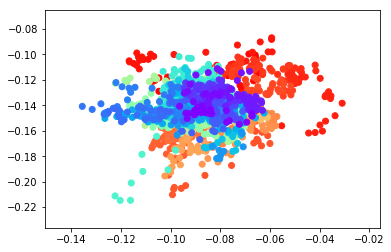

In [65]:
colors = cm.rainbow(np.linspace(1, 0, len(new_df)))
x1 = np.array(list(new_df.avg_embed_log))[:,0]
y1 = np.array(list(new_df.avg_embed_log))[:,2]
plt.scatter(x1, y1, color=colors)
plt.show()

# VAE

In [9]:
if not 'total_data' in dir():
    total_data = load_obj('upper1')
total_data = total_data.drop(['title'], axis=1)

### Model

In [63]:
class VAE_2d(object):

    def __init__(self, n_z=2, learning_rate=1e-3, beta=100):
        self.learning_rate = learning_rate
        self.n_z = n_z
        self.beta = beta

        self.build()
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, 100])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 64, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 64, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.elu)
        f4 = fc(f3, 64, scope='enc_fc4', activation_fn=tf.nn.elu)
        f5 = fc(f4, 32, scope='enc_fc5', activation_fn=tf.nn.elu)
        f6 = fc(f5, 32, scope='enc_fc6', activation_fn=tf.nn.elu)
        self.z_mu = fc(f6, self.n_z, scope='enc_fc7_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f6, self.n_z, scope='enc_fc7_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=0.001, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 32, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 32, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 64, scope='dec_fc3', activation_fn=tf.nn.elu)
        g4 = fc(g3, 64, scope='dec_fc4', activation_fn=tf.nn.elu)
        g5 = fc(g4, 64, scope='dec_fc5', activation_fn=tf.nn.elu)
        g6 = fc(g5, 64, scope='dec_fc6', activation_fn=tf.nn.elu)
        self.x_hat = fc(g6, 100, scope='dec_fc7', activation_fn=None)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        #'''
        recon_loss = tf.reduce_mean(tf.squared_difference(self.x_hat, self.x))
        '''
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat),
            axis=1
        )
        #'''
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + self.beta * latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat

    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z
    
    def restore(self, saver, ckpt):
        saver.restore(self.sess, ckpt)

### Input Generator & Trainer

In [29]:
embed_data = load_obj('embedding_data')

In [24]:
embed_data = title_embedding(total_data.lemmatized)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [27]:
save_obj(embed_data, 'embedding_data')

In [1]:
def title_embedding(lemmatized_list):
    x_gen = []
    for row in lemmatized_list:
        keywords = words2keywords(row)
        if len(keywords)==0:
            continue
        words, idf_scores = zip(*keywords)
        idf_scores = idf_scores/sum(idf_scores)

        avg_embedding = np.zeros(100, dtype=np.float32)
        for idx in range(len(words)):
            word = words[idx]
            embedding_vec = embedding[word]
            idf = idf_scores[idx]
            avg_embedding += idf*embedding_vec

        x_gen.append(avg_embedding)
    return np.array(x_gen)

In [82]:
def generator(lemmatized_list, bs=100):
    np.random.shuffle(lemmatized_list)
    for i in range(len(lemmatized_list)//bs):
        rows = lemmatized_list[bs*i:bs*(i+1)]
        x_gen = []
        for row in rows:
            keywords = words2keywords(row)
            if len(keywords)==0:
                continue
            words, idf_scores = zip(*keywords)
            idf_scores = idf_scores/sum(idf_scores)
            
            avg_embedding = np.zeros(100, dtype=np.float32)
            for idx in range(len(words)):
                word = words[idx]
                embedding_vec = embedding[word]
                idf = idf_scores[idx]
                avg_embedding += idf*embedding_vec
            
            x_gen.append(avg_embedding)
        yield np.array(x_gen)

def trainer(model, bs=1000, ne=200, print_on=True, print_step=1, save_step=10):
    st = time.time()
    saver = tf.train.Saver()

    for epoch in range(ne):
        np.random.shuffle(embed_data)
        #for batch in generator(list(total_data.lemmatized), bs):
        for i in range(len(embed_data)//bs):
            batch = embed_data[bs*i: bs*(i+1)]
        
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch)

        if (epoch+1) % print_step == 0:
            if print_on:
                x_recon = model.transformer(list(new_df.avg_embed_log))
                colors = cm.rainbow(np.linspace(1, 0, len(x_recon)))
                if model.n_z == 2:
                    x1 = x_recon[:, 0]
                    y1 = x_recon[:, 1]
                    #ax[0].set_xlim(-5, 5)
                    #ax[0].set_ylim(-5, 5)
                    plt.scatter(x1, y1, color=colors)
                    plt.show()
                else:
                    fig, ax = plt.subplots(1, model.n_z - 1, figsize=(10,10/(model.n_z-1)))
                    x1 = x_recon[:, 0]
                    for idx in range(1, model.n_z):
                        y1 = x_recon[:, idx]
                        #ax[0].set_xlim(-5, 5)
                        #ax[0].set_ylim(-5, 5)
                        ax[idx-1].scatter(x1, y1, color=colors, s=2)

                    plt.show()
                
                '''
                fig, ax = plt.subplots(1, 2, figsize=(10,3))
                
                x_recon = model.transformer(list(new_df.embed_log))
                colors = cm.rainbow(np.linspace(1, 0, len(x_recon)))
                x1 = x_recon[:, 0]
                y1 = x_recon[:, 1]
                #ax[0].set_xlim(-5, 5)
                #ax[0].set_ylim(-5, 5)
                ax[0].scatter(x1, y1, color=colors)
                
                x_recon = model.transformer(list(new_df.avg_embed_log))
                colors = cm.rainbow(np.linspace(1, 0, len(x_recon)))
                x1 = x_recon[:, 0]
                y1 = x_recon[:, 1]
                #ax[1].set_xlim(-+5, 5)
                #ax[1].set_ylim(-5, 5)
                ax[1].scatter(x1, y1, color=colors)
                plt.show()
                '''
            print('[Epoch %d] Loss: %.4f, Recon loss: %.4f, Latent loss: %.4f, Time: %.2f' %(
                epoch+1, loss, recon_loss, latent_loss, time.time()-st))
        if (epoch+1) % save_step == 0:
            saver.save(model.sess, './ckpt/mg_%d.ckpt'%(epoch+1))

    print('Done! - %.3f' %(time.time()-st))

/home/qara/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


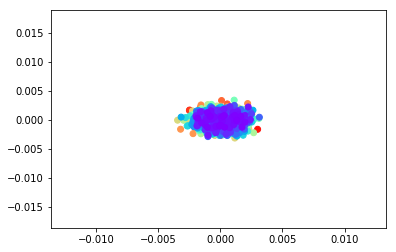

[Epoch 5] Loss: 0.0170, Recon loss: 0.0170, Latent loss: 0.0000, Time: 10.58


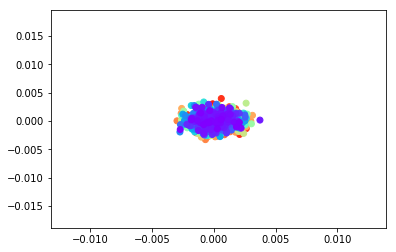

[Epoch 10] Loss: 0.0168, Recon loss: 0.0168, Latent loss: 0.0000, Time: 21.24


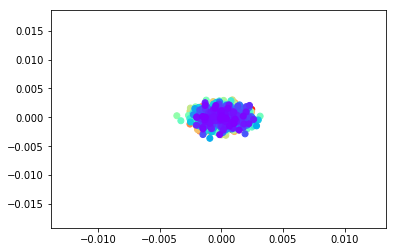

[Epoch 15] Loss: 0.0169, Recon loss: 0.0169, Latent loss: 0.0000, Time: 32.07


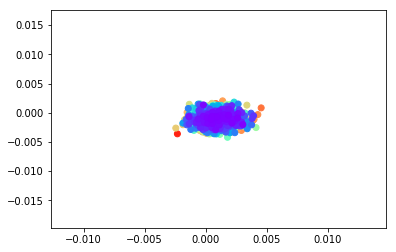

[Epoch 20] Loss: 0.0173, Recon loss: 0.0173, Latent loss: 0.0000, Time: 42.65


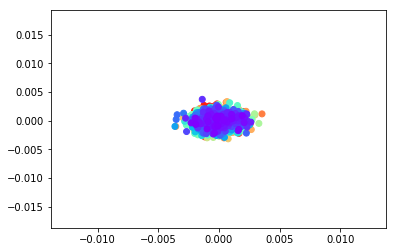

[Epoch 25] Loss: 0.0169, Recon loss: 0.0169, Latent loss: 0.0000, Time: 52.51


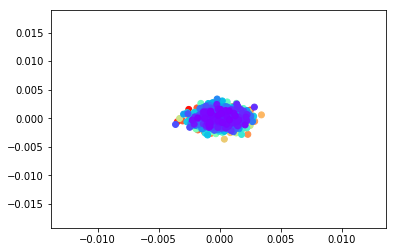

[Epoch 30] Loss: 0.0168, Recon loss: 0.0168, Latent loss: 0.0000, Time: 62.27


KeyboardInterrupt: 

In [85]:
if 'model' in dir():
    del model
tf.reset_default_graph() 
model = VAE_2d(n_z=2, learning_rate=1e-2, beta=0)
trainer(model, bs=10000, ne=200, print_step=5, save_step=5)

### Evaluation

In [216]:
model_name = 'mg_200'

tf.reset_default_graph()
model = VAE(n_z=2, learning_rate=1e-4, beta=10)
saver = tf.train.Saver()
model.restore(saver, './ckpt/%s.ckpt' %model_name)

INFO:tensorflow:Restoring parameters from ./ckpt/mg_25.ckpt


/home/qara/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [66]:
def title_embed(title):
    keywords = words2keywords(title)
    if len(keywords)==0:
        return
    words, idf_scores = zip(*keywords)
    idf_scores = idf_scores/sum(idf_scores)

    avg_embedding = np.zeros(100, dtype=np.float32)
    for idx in range(len(words)):
        word = words[idx]
        embedding_vec = embedding[word]
        idf = idf_scores[idx]
        avg_embedding += idf*embedding_vec

    return avg_embedding

In [67]:
title = total_data.lemmatized[1]
recon = model.reconstructor([title_embed(title)])
print(title)
print()
print(embedding.similar_by_vector(title_embed(title)))
print()
print(embedding.similar_by_vector(recon[0]))

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """


['president', 'obama', 'want', 'give', 'young', 'leader', 'world', 'tool', 'organize']

[('organize', 0.8307799100875854), ('socialize', 0.7752810716629028), ('invite', 0.7675635814666748), ('friend', 0.7585570216178894), ('listen', 0.7580553293228149), ('imagine', 0.7517143487930298), ('personally', 0.7458996176719666), ('remind', 0.7431463599205017), ('person', 0.7408796548843384), ('empower', 0.7408207654953003)]

[('politician', 0.8077096343040466), ('insist', 0.8055271506309509), ('obama', 0.7807105779647827), ('refuse', 0.7780690789222717), ('hate', 0.7775940895080566), ('complain', 0.7754483222961426), ('invite', 0.7733443975448608), ('recount', 0.7653408050537109), ('politicize', 0.764539897441864), ('friend', 0.7637702226638794)]


/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  import sys


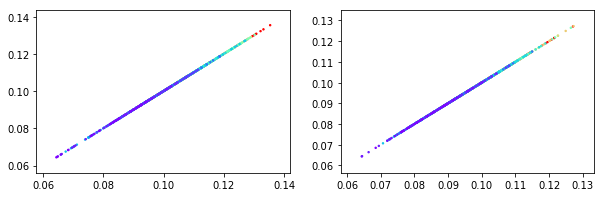

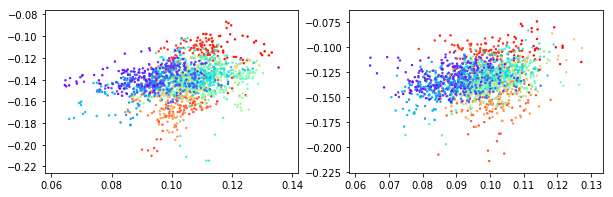

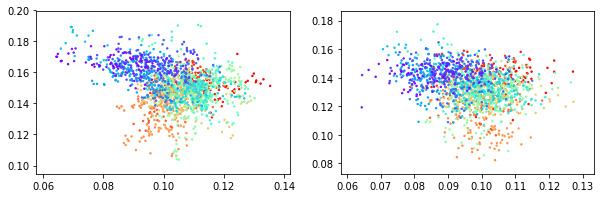

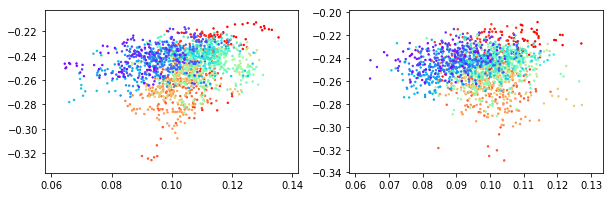

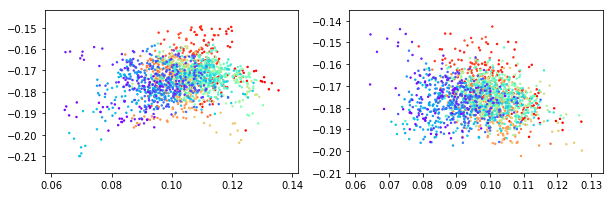

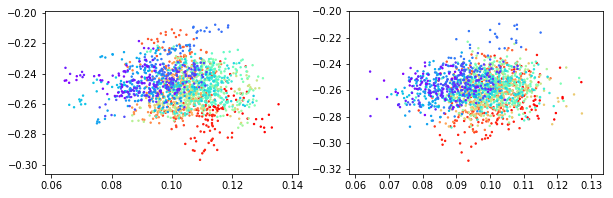

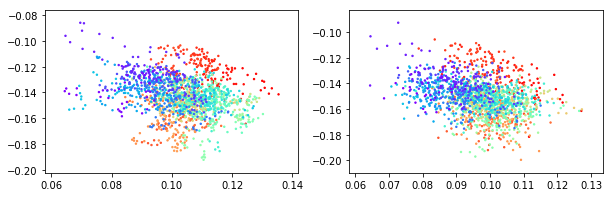

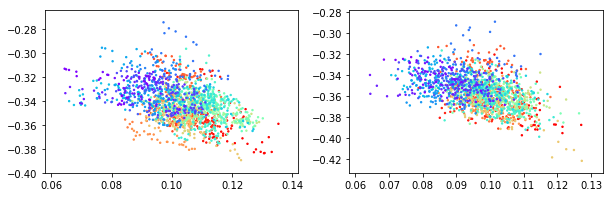

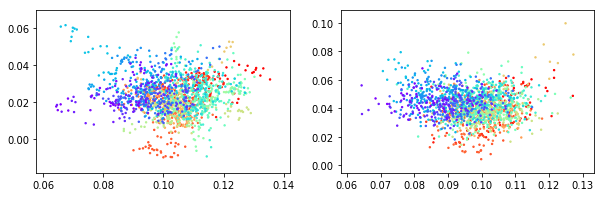

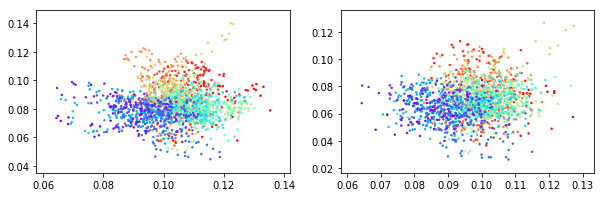

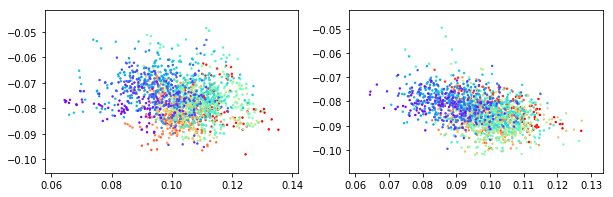

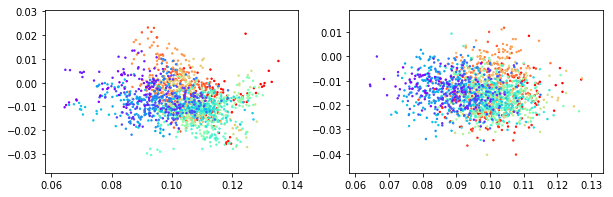

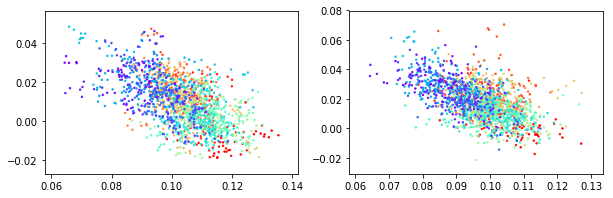

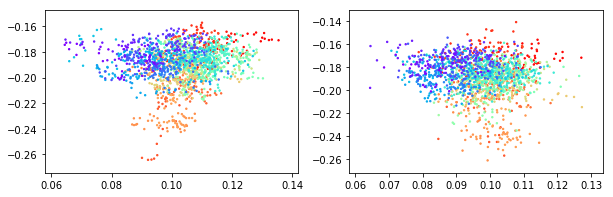

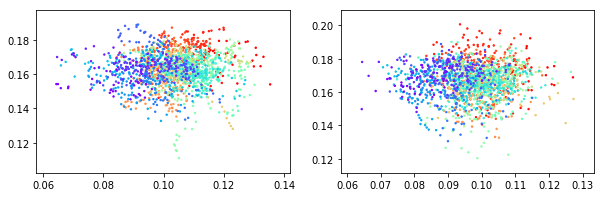

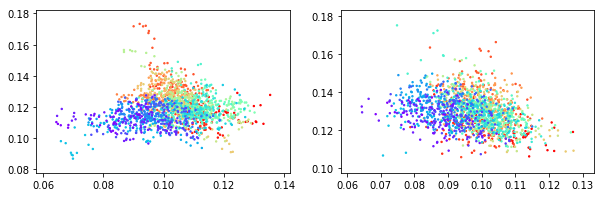

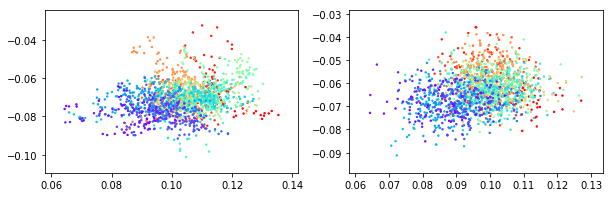

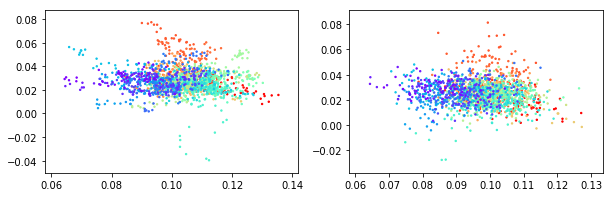

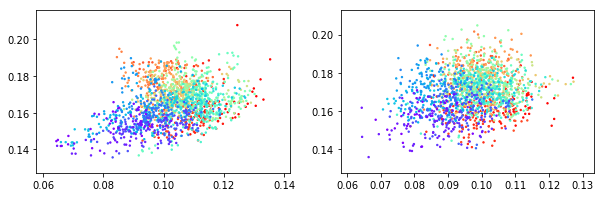

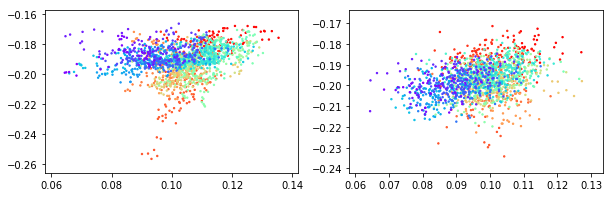

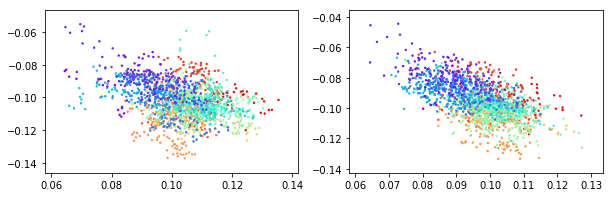

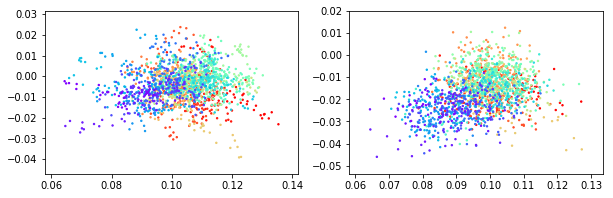

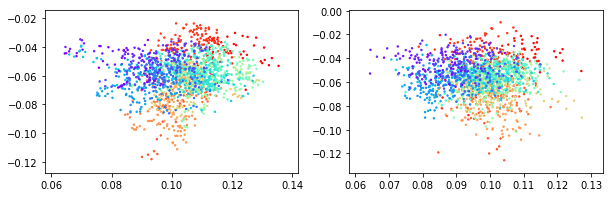

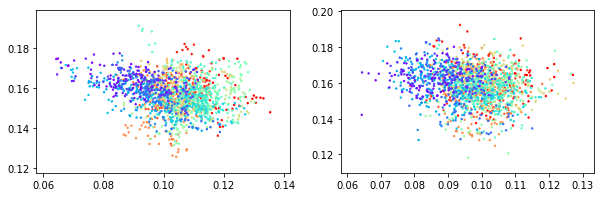

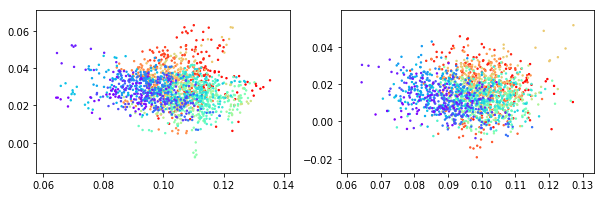

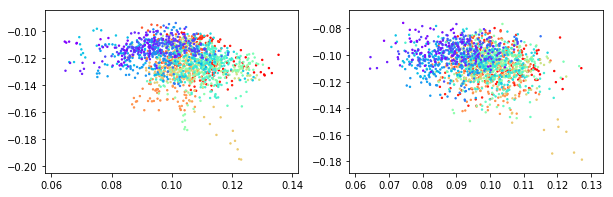

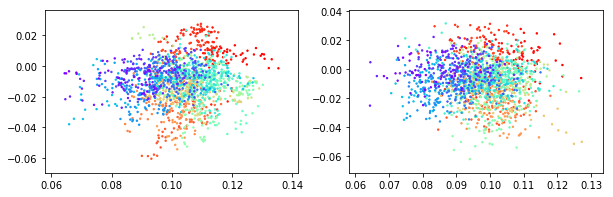

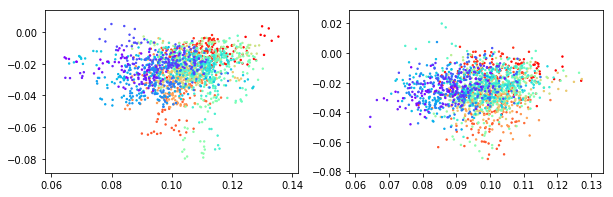

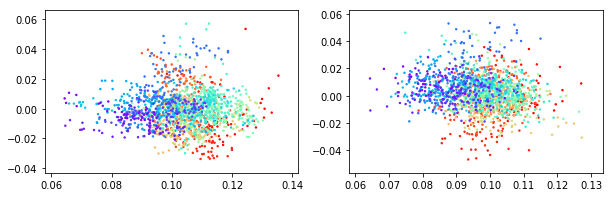

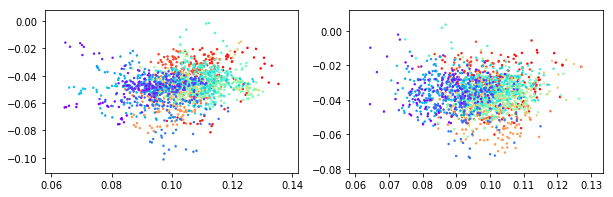

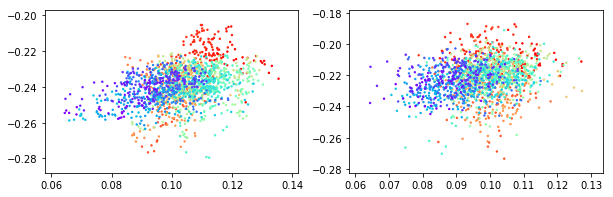

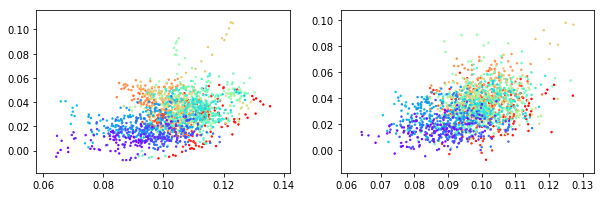

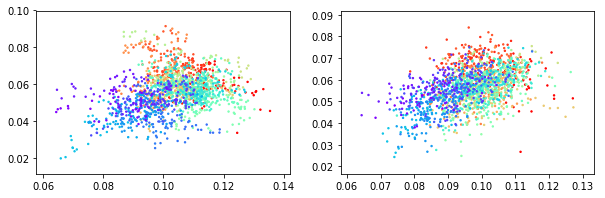

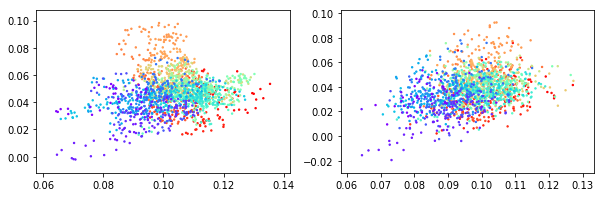

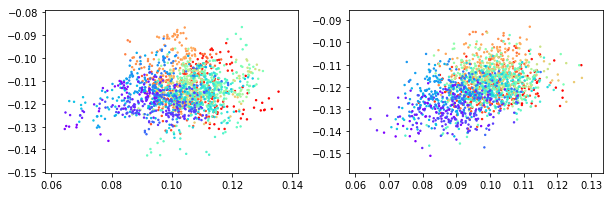

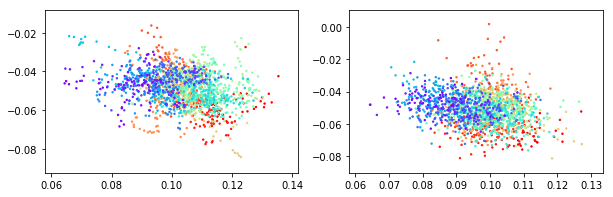

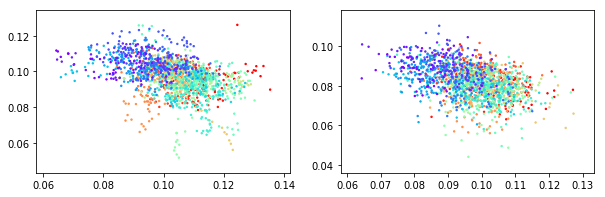

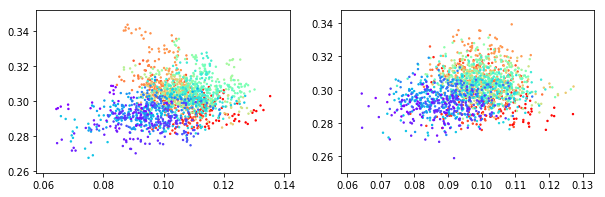

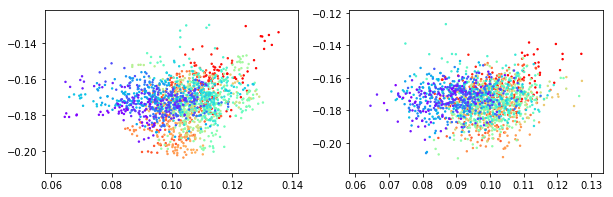

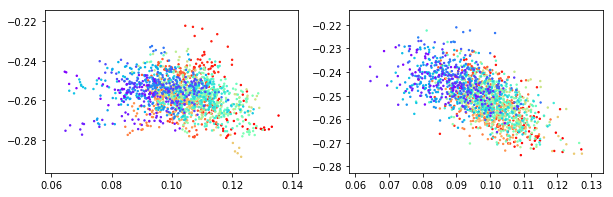

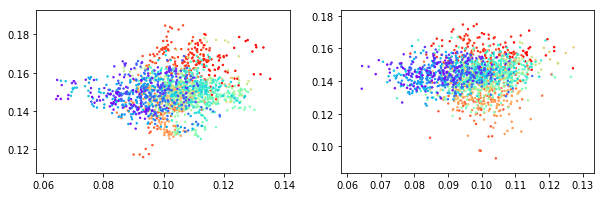

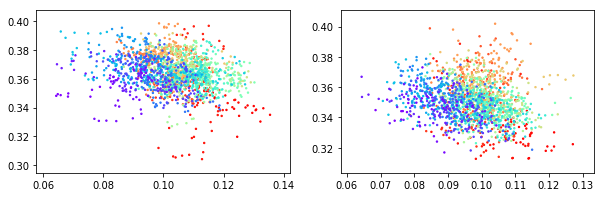

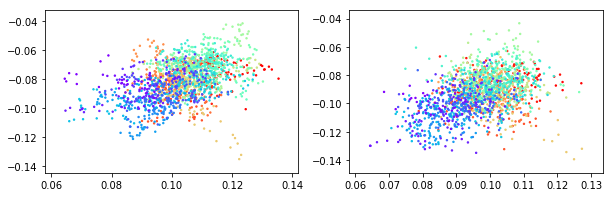

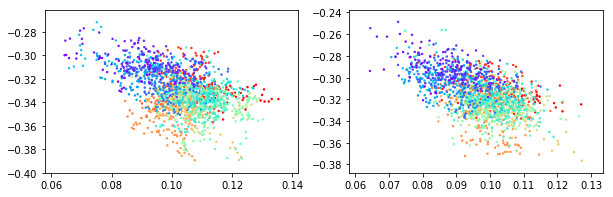

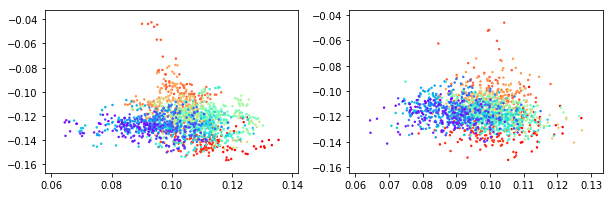

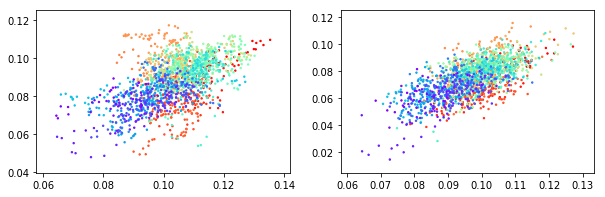

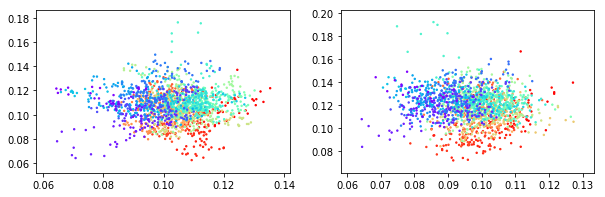

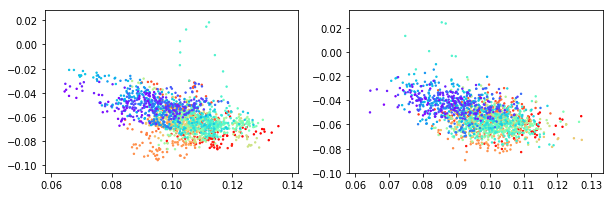

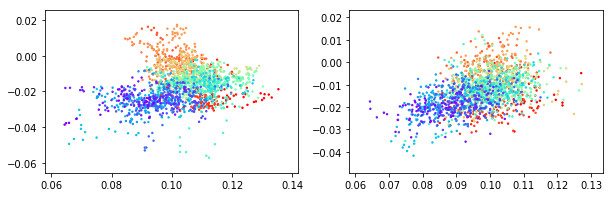

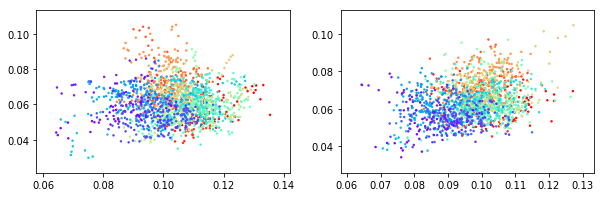

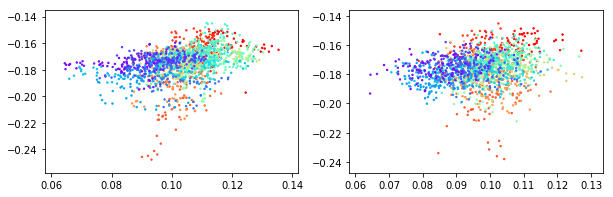

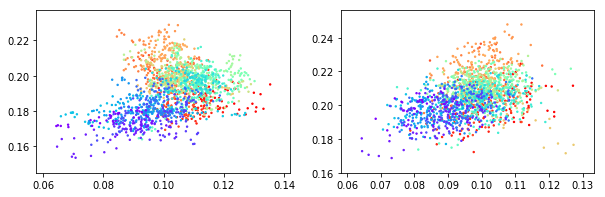

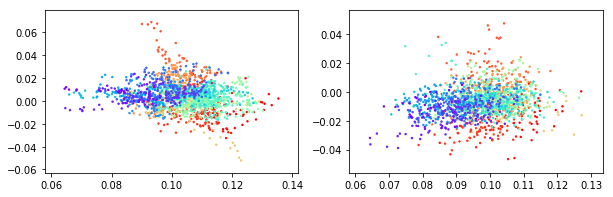

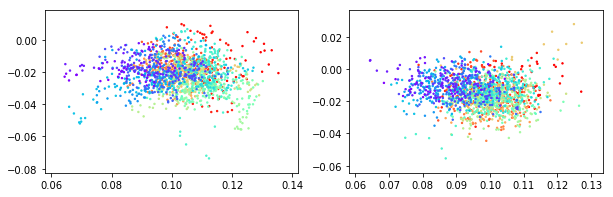

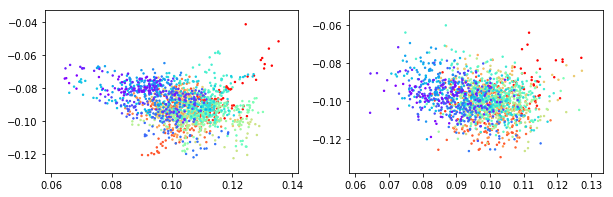

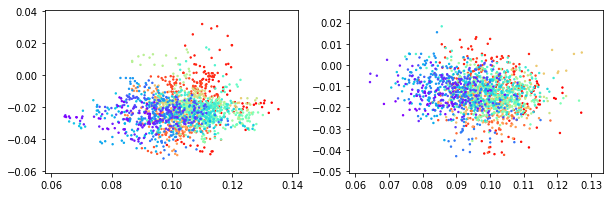

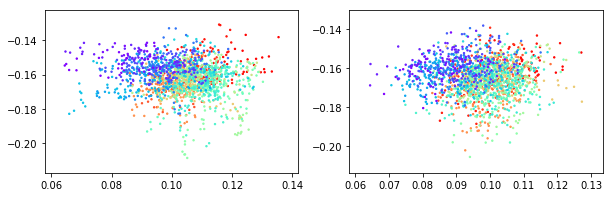

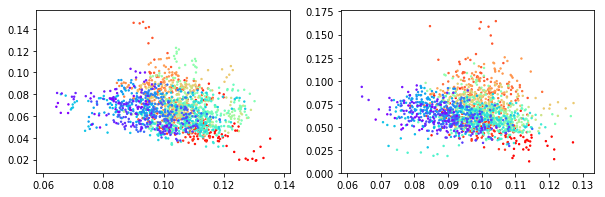

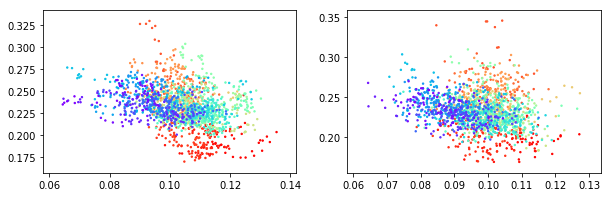

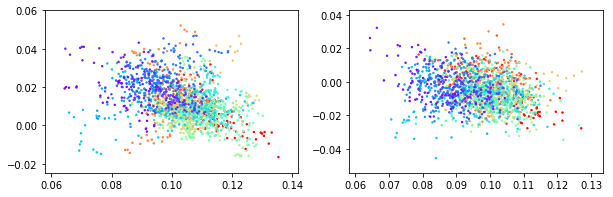

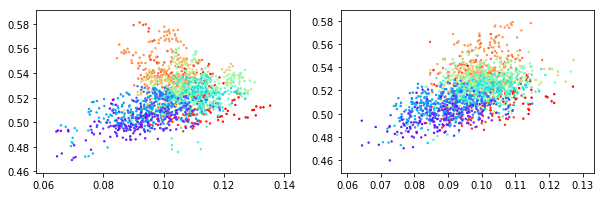

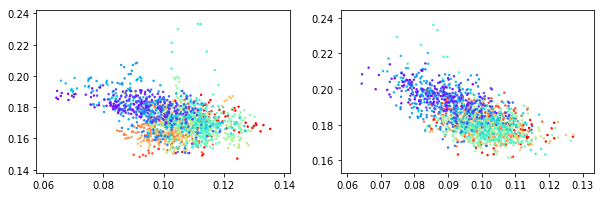

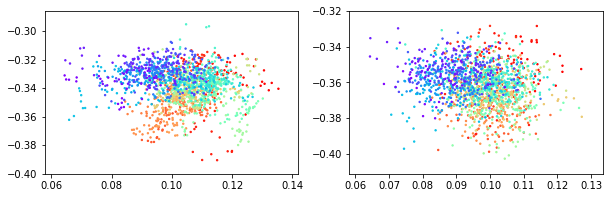

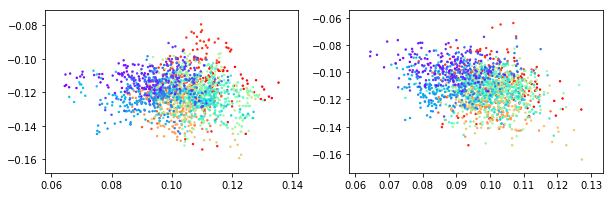

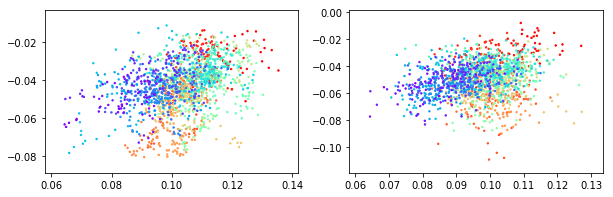

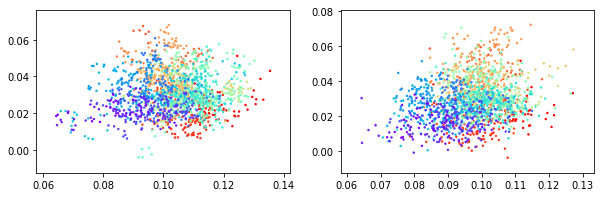

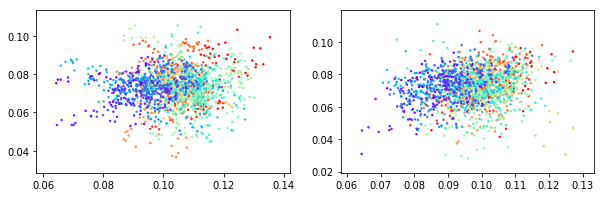

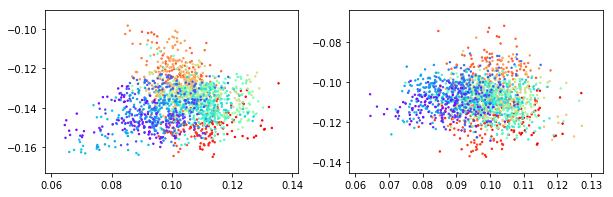

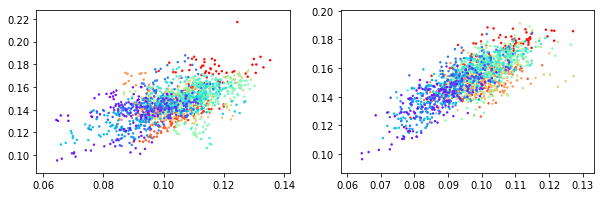

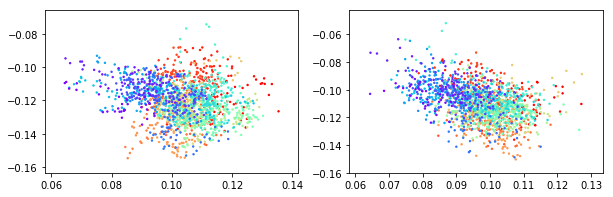

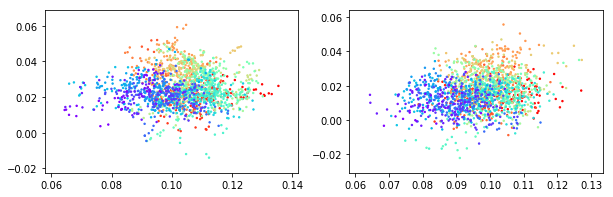

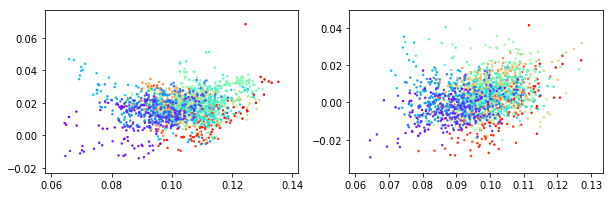

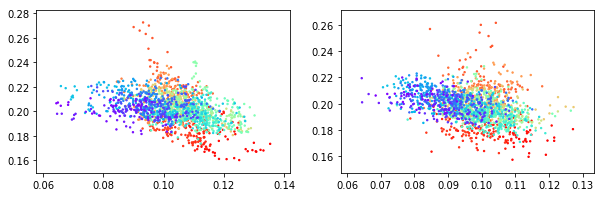

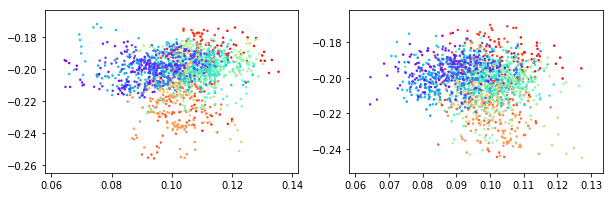

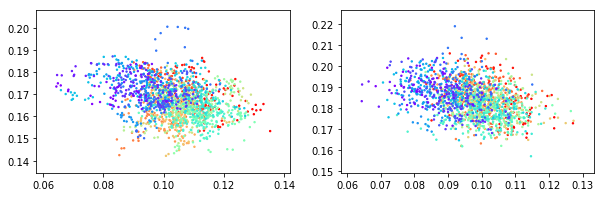

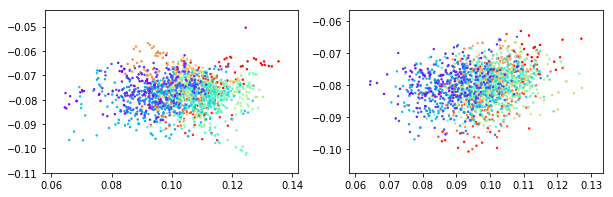

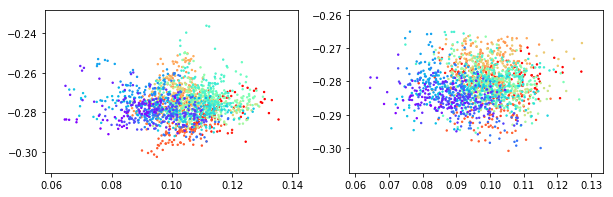

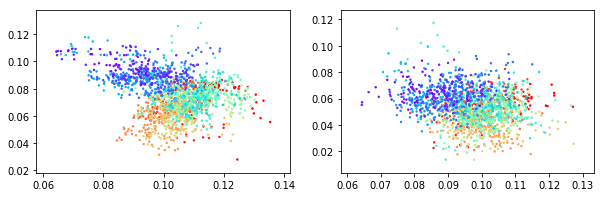

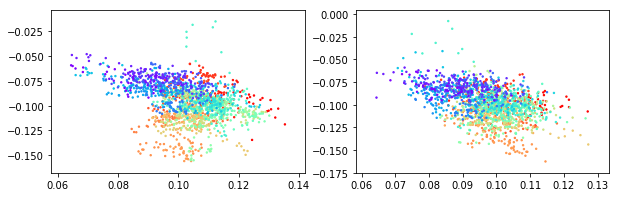

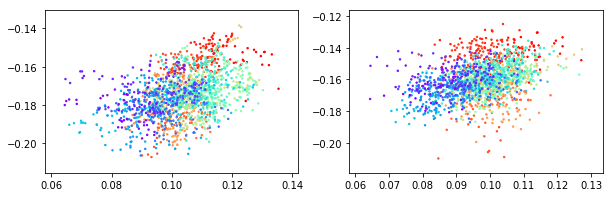

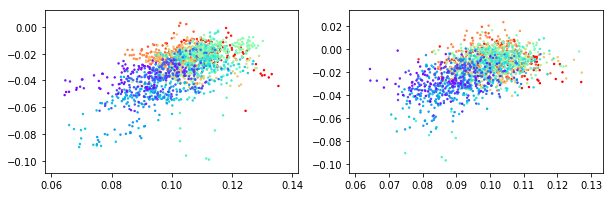

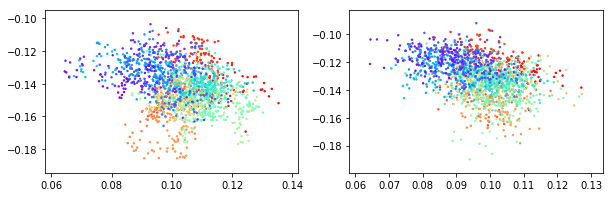

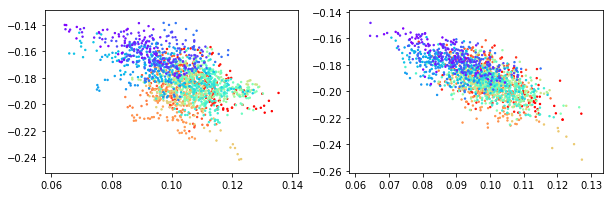

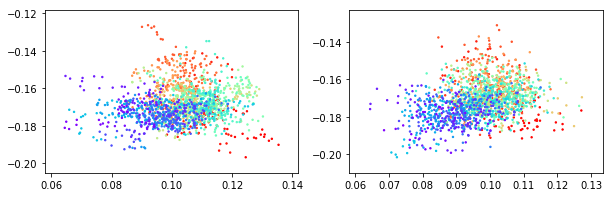

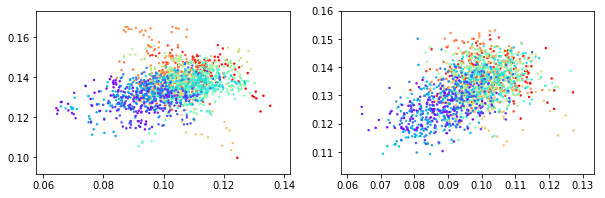

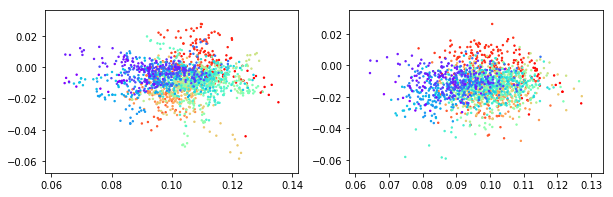

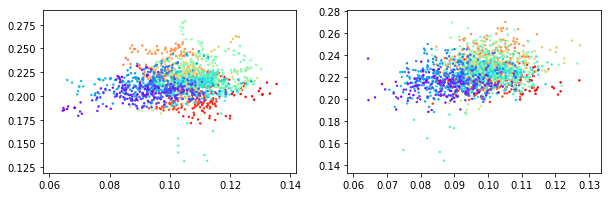

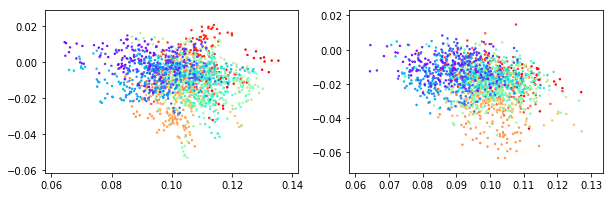

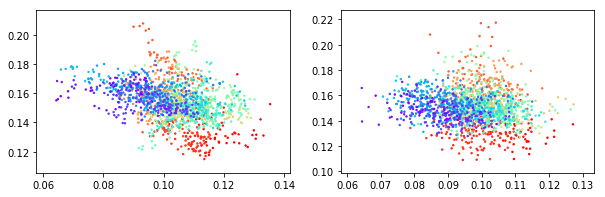

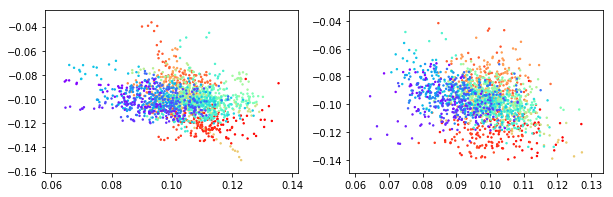

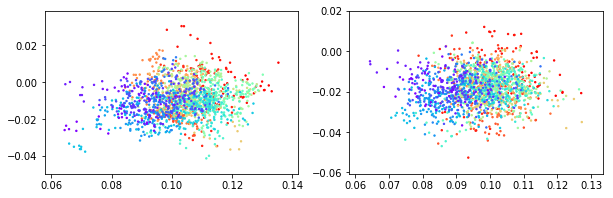

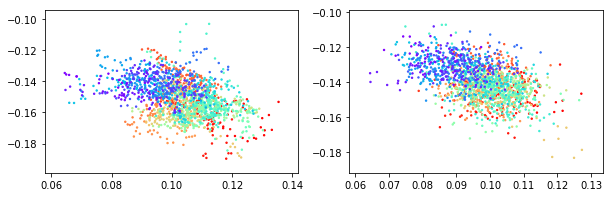

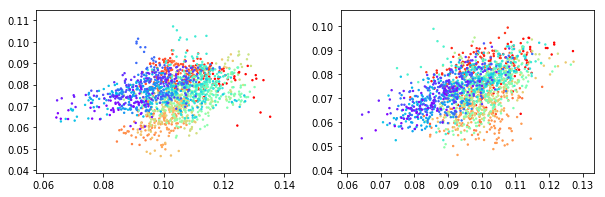

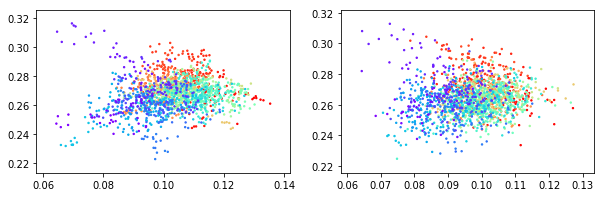

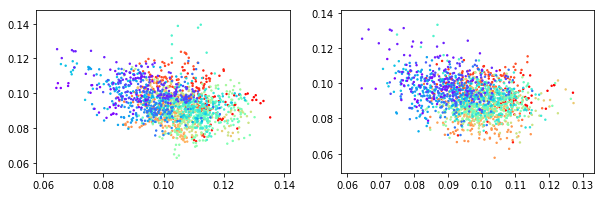

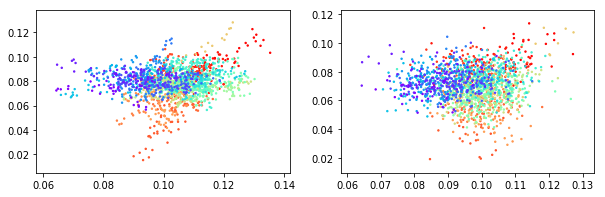

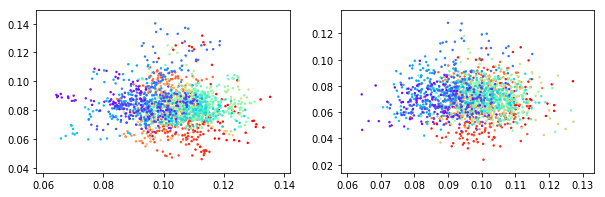

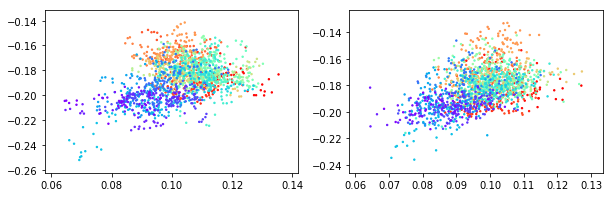

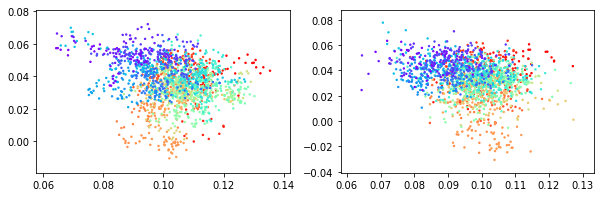

In [219]:
axis_1 = 1
axis_2 = 80

before = list(new_df.avg_embed_log)
after = model.reconstructor(before)

colors = cm.rainbow(np.linspace(1, 0, len(new_df)))

for axis_2 in range(1,100):
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    x1 = np.array(list(before))[:,axis_1]
    y1 = np.array(list(before))[:,axis_2]
    x2 = np.array(list(after))[:,axis_1]
    y2 = np.array(list(after))[:,axis_2]

    ax[0].scatter(x1, y1, color=colors, s=2)
    ax[1].scatter(x2, y2, color=colors, s=2)
    plt.show()